In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [3]:
# Build the model

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(10)
        self.dense_3 = Dense(5)
        self.softmax = Softmax()
        
    def call(self, inputs, training=True):
        x = self.dense_1(inputs)
        y1 = self.dense_2(inputs)
        y2 = self.dense_3(y1)
        concat = concatenate([x, y2])
        return self.softmax(concat)

In [4]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  704       
                                                                 
 dense_1 (Dense)             multiple                  110       
                                                                 
 dense_2 (Dense)             multiple                  55        
                                                                 
 softmax (Softmax)           multiple                  0         
                                                                 
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [6]:
# Create a custom layer

class MyLayer(Layer):
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                                initializer='zeros')

    def call(self, inputs):
        return tf.matmul(inputs, self.w)+self.b

dense_layer = MyLayer(3,5)
x = tf.ones((1,5))
print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[ 0.00166089 -0.2069714   0.0320729 ]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.10467035, -0.0617811 , -0.01746632],
       [ 0.04820874, -0.01423195, -0.07867721],
       [-0.03222032, -0.02024343,  0.04560738],
       [ 0.04079464, -0.02415482,  0.02702134],
       [ 0.04954818, -0.08656011,  0.05558771]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [7]:
# Specify trainable weights

class MyLayer(Layer):
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                initializer='random_normal',
                                trainable=False)
        self.b = self.add_weight(shape=(units,),
                                initializer='zeros',
                                trainable=False)

    def call(self, inputs):
        return tf.matmul(inputs, self.w)+self.b

dense_layer = MyLayer(3,5)

In [8]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [9]:
# Create a custom layer to accumulate means of output values

class MyLayerMean(Layer):
    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                                initializer='zeros')

        self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)),
                                trainable=False)
        self.number_call = tf.Variable(initial_value=0,
                                trainable=False)

    def call(self, inputs):
        activations = tf.matmul(inputs, self.w)+self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_call.assign_add(inputs.shape[0])
        return activations, self.sum_activation/tf.cast(self.number_call, tf.float32)

dense_layer = MyLayerMean(3,5)

In [10]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[0.11861629 0.15034133 0.10757937]
[0.11861629 0.15034133 0.10757937]


In [11]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [12]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)

        return self.softmax(x)

In [13]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.02043886 0.018892   0.00504323 0.00702609 0.00602255 0.0160606
  0.01388337 0.00614327 0.04018324 0.01170332 0.06393178 0.00274738
  0.00991261 0.03947646 0.0542675  0.03041628 0.00626599 0.00394563
  0.02967362 0.03478213 0.01246471 0.00915952 0.02113009 0.14767838
  0.02491972 0.01952385 0.01051522 0.01238433 0.01784358 0.01315954
  0.01530374 0.01594071 0.01330764 0.01816556 0.01597342 0.00787557
  0.04333362 0.00926325 0.04538442 0.01518556 0.00376374 0.03747208
  0.02336606 0.01283197 0.00288287 0.01035486]], shape=(1, 46), dtype=float32)
Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer_2 (MyLayer)        multiple                  640064    
                                                                 
 my_dropout (MyDropout)      multiple                  0         
                                                                 
 my_layer_3 (MyLaye

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [14]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

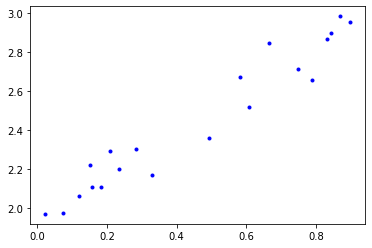

In [15]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [16]:
from tensorflow.keras.layers import Layer

In [17]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):
    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(shape=(1,),
                                initializer='random_normal')
        self.b = self.add_weight(shape=(1,),
                                initializer='zeros')

    def call(self, inputs):
        return self.m*inputs+self.b

linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[0.00010883 0.00282473 0.00348122 0.00402981 0.00085279 0.00069954
 0.00033996 0.00131417 0.00073281 0.00416598 0.00055425 0.00270355
 0.00308377 0.00153424 0.00386154 0.0036581  0.00391949 0.0022936
 0.00096996 0.00109325], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.00464159], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [18]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.084328


#### Train and plot the model

In [19]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 25

for i in range(steps):

    with tf.GradientTape() as tape:
        predictions = linear_regression(x_train)
        loss = SquaredError(predictions, y_train)

    gradients = tape.gradient(loss, linear_regression.trainable_variables)

    linear_regression.m.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[1])

    print("Step %d, Loss %f" % (i, loss.numpy()))

Step 0, Loss 6.084328
Step 1, Loss 4.688845
Step 2, Loss 3.613883
Step 3, Loss 2.785821
Step 4, Loss 2.147951
Step 5, Loss 1.656587
Step 6, Loss 1.278080
Step 7, Loss 0.986507
Step 8, Loss 0.761901
Step 9, Loss 0.588881
Step 10, Loss 0.455598
Step 11, Loss 0.352925
Step 12, Loss 0.273832
Step 13, Loss 0.212902
Step 14, Loss 0.165964
Step 15, Loss 0.129803
Step 16, Loss 0.101946
Step 17, Loss 0.080484
Step 18, Loss 0.063948
Step 19, Loss 0.051208
Step 20, Loss 0.041391
Step 21, Loss 0.033826
Step 22, Loss 0.027996
Step 23, Loss 0.023502
Step 24, Loss 0.020038


m:1,  trained m:[0.9681438]
b:2,  trained b:[1.9145575]


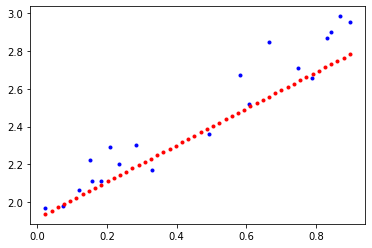

In [20]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [23]:
# Define the custom layers and model

class MyLayer(Layer):
    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                initializer='random_normal',
                                name='kernal')
        self.b = self.add_weight(shape=(self.units,),
                                initializer='zeros',
                                name='bias')

    def call(self, inputs):
        return tf.matmul(inputs, self.w)+self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)

        return self.softmax(x)

In [24]:
# Instantiate the model object

model = MyModel(64, 64, 46)
print(model(tf.ones((1,10000))))
model.summary()

tf.Tensor(
[[0.04957097 0.0099104  0.00895562 0.00901272 0.04854007 0.00819034
  0.0176255  0.00983141 0.02383919 0.00845482 0.01710371 0.02598346
  0.01828106 0.01560017 0.01392732 0.00694153 0.01654278 0.00425274
  0.01275168 0.00765594 0.00484097 0.08922577 0.0177878  0.05045633
  0.00622576 0.02696894 0.04526999 0.02167953 0.00860764 0.00650277
  0.05112039 0.03667638 0.02686141 0.03669357 0.02261266 0.01754647
  0.01277053 0.01056651 0.04092805 0.00706399 0.00896897 0.02635867
  0.01353471 0.01006997 0.06301527 0.00467558]], shape=(1, 46), dtype=float32)
Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer_5 (MyLayer)        multiple                  640064    
                                                                 
 my_dropout_2 (MyDropout)    multiple                  0         
                                                                 
 my_layer_6 (MyLay

#### Load the reuters dataset and define the class_names 

In [25]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [26]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [27]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [28]:
# Print the first data example sentence

print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [29]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [30]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [31]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [32]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        epoch_loss_avg(loss_value)
        epoch_accuracy(to_categorical(y), model(x))

        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:0.3f}, Accuracy: {:.3f}".format(epoch,epoch_loss_avg.result(), epoch_accuracy.result()))

    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000: Loss: 2.090, Accuracy: 0.473
Epoch 001: Loss: 1.428, Accuracy: 0.653
Epoch 002: Loss: 1.194, Accuracy: 0.706
Epoch 003: Loss: 1.050, Accuracy: 0.736
Epoch 004: Loss: 0.940, Accuracy: 0.757
Epoch 005: Loss: 0.854, Accuracy: 0.773
Epoch 006: Loss: 0.781, Accuracy: 0.793
Epoch 007: Loss: 0.734, Accuracy: 0.807
Epoch 008: Loss: 0.670, Accuracy: 0.814
Epoch 009: Loss: 0.631, Accuracy: 0.826
Duration :60.394


#### Evaluate the model

In [33]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [34]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [35]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.444
Test accuracy: 72.173%


#### Plot the learning curves

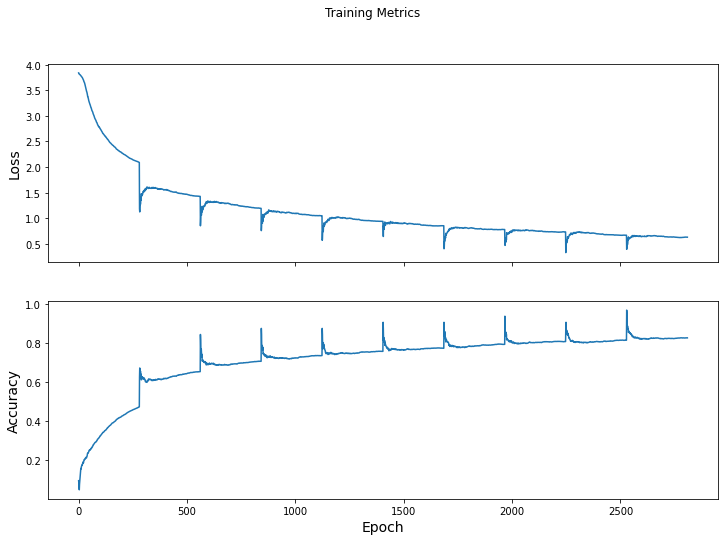

In [36]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [37]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [39]:
# Initialize a new model

model = MyModel(64, 64, 46)


#### Redefine the grad function using the @tf.function decorator

In [40]:
# Use the @tf.function decorator
@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [41]:
# Re-run the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        epoch_loss_avg(loss_value)
        epoch_accuracy(to_categorical(y), model(x))

        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:0.3f}, Accuracy: {:.3f}".format(epoch,epoch_loss_avg.result(), epoch_accuracy.result()))

    
print("Duration : {:.3f}".format(time.time() - start_time))

Epoch 000: Loss: 1.765, Accuracy: 0.587
Epoch 001: Loss: 1.300, Accuracy: 0.686
Epoch 002: Loss: 1.137, Accuracy: 0.713
Epoch 003: Loss: 1.025, Accuracy: 0.733
Epoch 004: Loss: 0.942, Accuracy: 0.753
Epoch 005: Loss: 0.868, Accuracy: 0.771
Epoch 006: Loss: 0.818, Accuracy: 0.780
Epoch 007: Loss: 0.765, Accuracy: 0.788
Epoch 008: Loss: 0.727, Accuracy: 0.797
Epoch 009: Loss: 0.688, Accuracy: 0.802
Duration :39.584


#### Print the autograph code

In [42]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

